### Kamery zdarzeniowe

In [1]:
### help fun 
import matplotlib.pyplot as plt

def plot(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [2]:
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm
import numpy as np

path = Path(r'/home/plorenc/Desktop/AiR_ISS/AVS/shapes_rotation/events.txt')

with open (path, 'r') as file:
    data = file.read()

data = data.split('\n')

rows = [row.split() for row in tqdm(data)]

df = pd.DataFrame(rows, columns=['timesteps', 'x', 'y', 'value'])
df = df.dropna()

df['timesteps'] = df['timesteps'].astype(np.float16)
df['x'] = df['x'].astype(np.int8)
df['y'] = df['y'].astype(np.int8)
df['value'] = df['value'].astype(np.int8)

df.head()          

/home/plorenc/Desktop/AiR_ISS/OpenCL/lab3/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 23126289/23126289 [00:22<00:00, 1012870.07it/s]


,timesteps,x,y,value
0,0.000000,33,39,1
1,0.000011,-98,-111,1
2,0.000050,88,-113,0
3,0.000055,-82,-102,0
4,0.000080,112,-117,1


In [3]:
try:
    del rows, data
except:
    "git"

df = df[df['timesteps'] > 1]
df.head(1)

,timesteps,x,y,value
72167,1.000977,-23,23,1


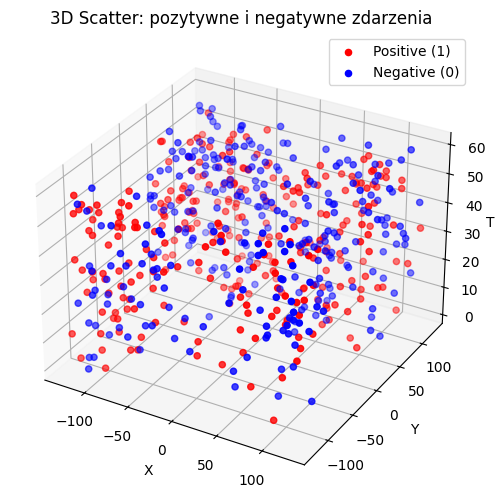

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df_positive = df[df['value'] == 1]  
df_negative = df[df['value'] == 0]  


df_positive_sample = df_positive.sample(n=300, random_state=42)
df_negative_sample = df_negative.sample(n=300, random_state=42)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_positive_sample['x'], df_positive_sample['y'], df_positive_sample['timesteps'],
           c='red', label='Positive (1)')

ax.scatter(df_negative_sample['x'], df_negative_sample['y'], df_negative_sample['timesteps'],
           c='blue', label='Negative (0)')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Time')
ax.set_title('3D Scatter: pozytywne i negatywne zdarzenia')
ax.legend()
plt.show()

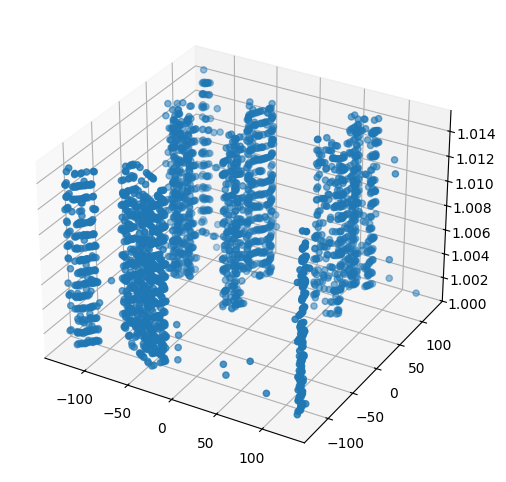

In [5]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')  


df_3000 = df.iloc[0:3000]

ax.scatter(df_3000['x'], df_3000['y'], df_3000['timesteps'])

### Event frame

In [43]:
def EventFrame(x: np.array, y: np.array, t: np.array, polarity: np.array, time_stamp: tuple) -> np.array:
    x_resolution = abs(int(x.max()) - int(x.min()))
    y_resolution = abs(int(y.max()) - int(y.min()))

    time_surface = np.full((y_resolution, x_resolution), 127, dtype=np.uint8)

    time_mask = (t >= time_stamp[0]) & (t <= time_stamp[1])
    x = x[time_mask]
    y = y[time_mask]
    polarity = polarity[time_mask]

    for dx, dy, polar in zip(x, y, polarity):
        if polar == 0:
            time_surface[dy, dx] = 0
        elif polar == 1:
            time_surface[dy, dx] = 255

    return time_surface


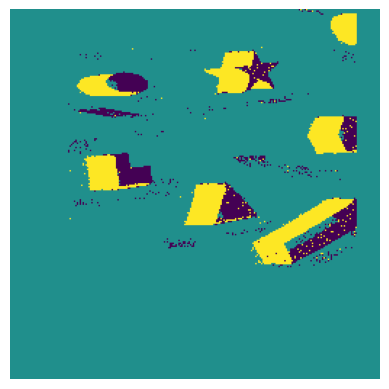

In [47]:
ts = EventFrame(np.array(df['x']), np.array(df['y']), np.array(df['timesteps']), np.array(df['value']), (1, 1.2))

plot(ts)

### Exponentially decaying time surface

In [53]:
def EventFrameWithTimeDecay(x: np.array, y: np.array, t: np.array, polarity: np.array, time_window: tuple, tau: float = 0.1) -> np.array:
    x_resolution = abs(int(x.max()) - int(x.min()))
    y_resolution = abs(int(y.max()) - int(y.min()))

    time_surface = np.full((y_resolution, x_resolution), 127, dtype=np.uint8)

    time_mask = (t >= time_window[0]) & (t <= time_window[1])
    x = x[time_mask]
    y = y[time_mask]
    polarity = polarity[time_mask]
    times = t[time_mask]

    for dx, dy, polar, time in zip(x, y, polarity, times):
        weight = np.exp((time - time_window[1]) / tau)
        
        if polar == 0:
            time_surface[dy, dx] = 0
        elif polar == 1:
            time_surface[dy, dx] = min(255, int(weight * 255))

    return time_surface

        

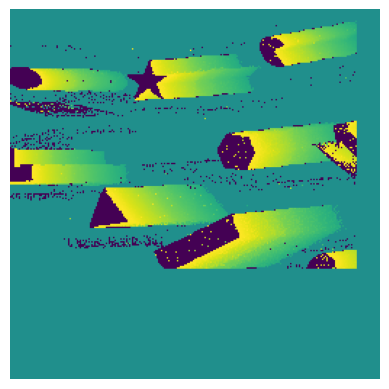

In [60]:
ts = EventFrameWithTimeDecay(np.array(df['x']), np.array(df['y']), np.array(df['timesteps']), np.array(df['value']), (1.5, 2), 1)

plot(ts)

### Event frequency 

In [89]:
def EventFrequency(x: np.array, y: np.array, t: np.array, polarity: np.array, time_window: tuple) -> np.array:
    x_resolution = abs(int(x.max()) - int(x.min()))
    y_resolution = abs(int(y.max()) - int(y.min()))

    time_surface = np.zeros((x_resolution, y_resolution), dtype=np.uint8)

    time_mask = (t >= time_window[0]) & (t <= time_window[1])
    x = x[time_mask]
    y = y[time_mask]
    polarity = polarity[time_mask]

    for (dx, dy, polar) in zip(x, y, polarity):
        time_surface[dy, dx] += polar


    time_surface = 255*1/(1 + np.exp(-time_surface/2))

    return time_surface

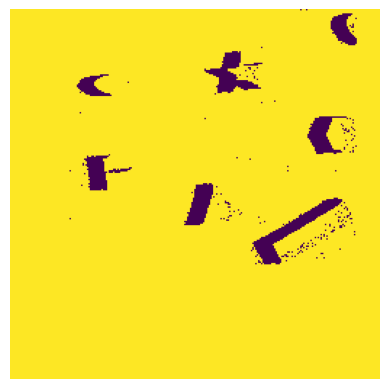

In [90]:
import cv2

ts = EventFrequency(np.array(df['x']), np.array(df['y']), np.array(df['timesteps']), np.array(df['value']), (1, 1.1))

plot(ts)